In [2]:
! pip install torch torchvision torchaudio torch-geometric matplotlib networkx

   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   --------------------------------- ------ 2.1/2.5 MB 16.8 MB/s eta 0:00:01
   ---------------------------------------- 2.5/2.5 MB 15.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 1.1/1.1 MB 13.9 MB/s eta 0:00:00


In [63]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Amazon
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import networkx as nx

In [66]:
data['y']

tensor([4, 4, 8,  ..., 8, 4, 0])

In [64]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset = Amazon(root='./data', name='Computers')
data = dataset[0].to(device)

print(data)

indices = torch.randperm(data.num_nodes)
train_size = int(0.6 * data.num_nodes)
val_size = int(0.2 * data.num_nodes)
test_size = data.num_nodes - train_size - val_size

train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)

train_mask[indices[:train_size]] = True
val_mask[indices[train_size:train_size+val_size]] = True
test_mask[indices[train_size+val_size:]] = True

data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

Data(x=[13752, 767], edge_index=[2, 491722], y=[13752])


In [6]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 64)
        self.conv2 = GCNConv(64, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training, p=0.5)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


In [18]:
model = GCN(num_features=dataset.num_features, num_classes=dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [19]:
epochs = 300

losses = []

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test(mask):
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    correct = pred[mask] == data.y[mask]
    acc = int(correct.sum()) / int(mask.sum())
    return acc

for epoch in range(1, epochs + 1):
    loss = train()
    if epoch % 10 == 0:
        train_acc = test(data.train_mask)
        val_acc = test(data.val_mask)
        losses.append(loss)
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

Epoch: 010, Loss: 2.0499, Train Acc: 0.4763, Val Acc: 0.4782
Epoch: 020, Loss: 1.5188, Train Acc: 0.6352, Val Acc: 0.6309
Epoch: 030, Loss: 1.1411, Train Acc: 0.7300, Val Acc: 0.7265
Epoch: 040, Loss: 0.8550, Train Acc: 0.7668, Val Acc: 0.7709
Epoch: 050, Loss: 0.6851, Train Acc: 0.8245, Val Acc: 0.8204
Epoch: 060, Loss: 0.5890, Train Acc: 0.8593, Val Acc: 0.8516
Epoch: 070, Loss: 0.5294, Train Acc: 0.8764, Val Acc: 0.8720
Epoch: 080, Loss: 0.4840, Train Acc: 0.8775, Val Acc: 0.8742
Epoch: 090, Loss: 0.4448, Train Acc: 0.8923, Val Acc: 0.8844
Epoch: 100, Loss: 0.4310, Train Acc: 0.8966, Val Acc: 0.8840
Epoch: 110, Loss: 0.4198, Train Acc: 0.9006, Val Acc: 0.8891
Epoch: 120, Loss: 0.3976, Train Acc: 0.9046, Val Acc: 0.8942
Epoch: 130, Loss: 0.3820, Train Acc: 0.9112, Val Acc: 0.8956
Epoch: 140, Loss: 0.3746, Train Acc: 0.9036, Val Acc: 0.8920
Epoch: 150, Loss: 0.3748, Train Acc: 0.9032, Val Acc: 0.8916
Epoch: 160, Loss: 0.3707, Train Acc: 0.9087, Val Acc: 0.8935
Epoch: 170, Loss: 0.3544

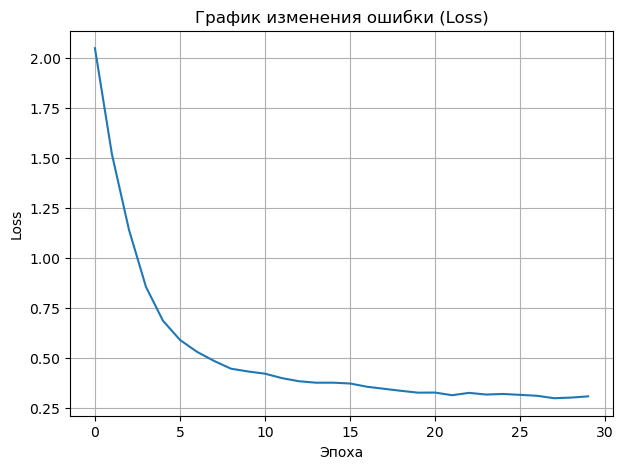

In [20]:
plt.figure(figsize=(7, 5))
plt.plot(losses)
plt.title('График изменения ошибки (Loss)')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

Accuracy на подграфе из 50 узлов: 0.9200


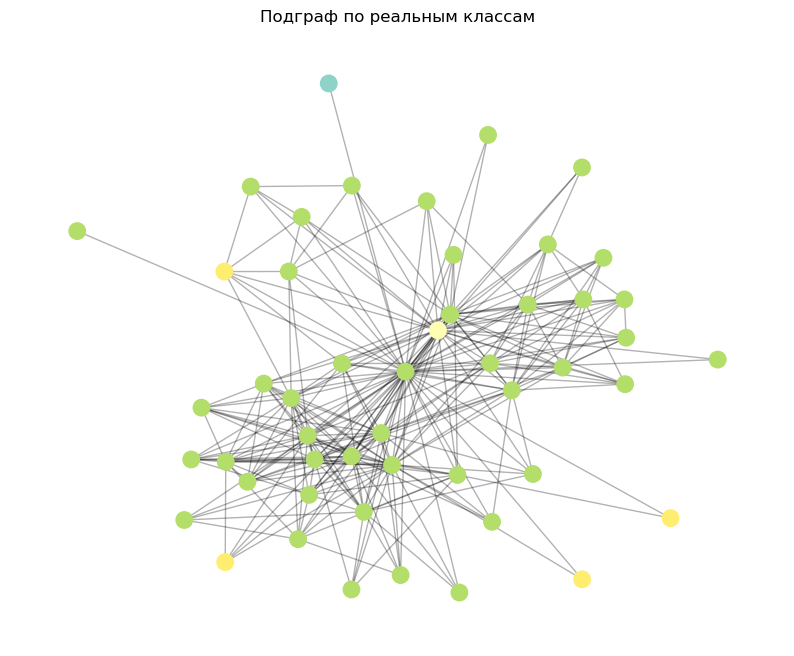

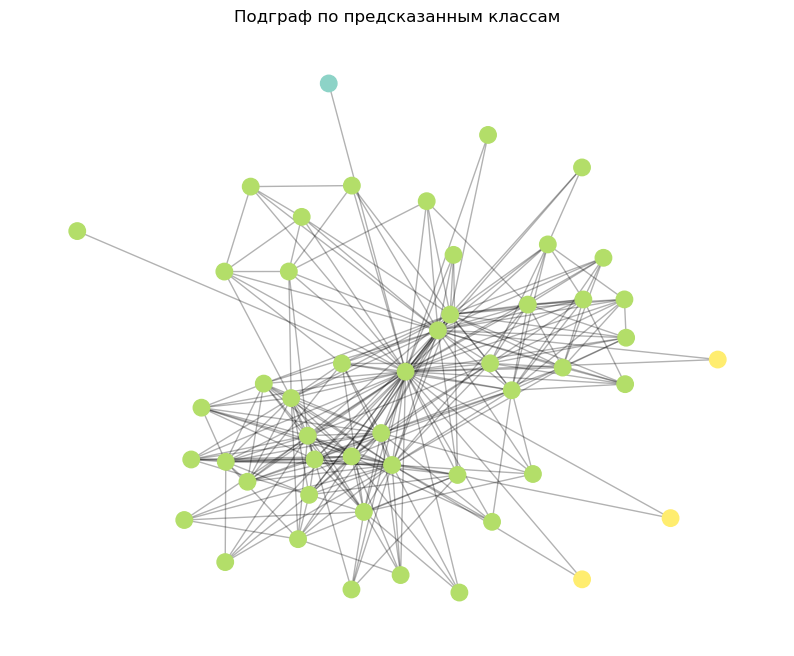

In [62]:
import random
import torch
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from torch_geometric.utils import to_networkx

model.eval()
out = model(data)
pred = out.argmax(dim=1)

G = to_networkx(data, to_undirected=True)

true_classes = data.y.cpu().numpy()
pred_classes = pred.cpu().numpy()

for i in G.nodes():
    G.nodes[i]['true_class'] = true_classes[i]
    G.nodes[i]['pred_class'] = pred_classes[i]

def get_connected_subgraph(G, center_node, max_nodes=50):
    lengths = nx.single_source_shortest_path_length(G, center_node)

    sorted_nodes = sorted(lengths.items(), key=lambda x: x[1])

    if len(sorted_nodes) <= max_nodes:
        selected_nodes = [node for node, dist in sorted_nodes]
    else:
        selected_nodes = [node for node, dist in sorted_nodes[:max_nodes]]

    subgraph = G.subgraph(selected_nodes)
    return subgraph

center_node = random.choice(list(G.nodes))
subgraph = get_connected_subgraph(G, center_node, max_nodes=50)

pos = nx.spring_layout(subgraph, seed=42)


nodes = list(subgraph.nodes)
correct = sum(int(G.nodes[n]['true_class'] == G.nodes[n]['pred_class']) for n in nodes)
accuracy = correct / len(nodes)
print(f"Accuracy на подграфе из {len(nodes)} узлов: {accuracy:.4f}")

def plot_graph(subgraph, pos, color_attr, title):
    node_colors = [subgraph.nodes[i][color_attr] for i in subgraph.nodes()]
    classes = sorted(set(node_colors))

    plt.figure(figsize=(10, 8))
    nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors, cmap=plt.cm.Set3, node_size=140)
    nx.draw_networkx_edges(subgraph, pos, alpha=0.3)
    plt.title(title)
    plt.axis('off')
    plt.show()

plot_graph(subgraph, pos, 'true_class', 'Подграф по реальным классам')

plot_graph(subgraph, pos, 'pred_class', 'Подграф по предсказанным классам')